In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)

Train shape: (50000, 32, 32, 3) (50000, 1)
Test shape: (10000, 32, 32, 3) (10000, 1)


In [4]:
# Normalisasi
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Split train -> train + validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

print("Train:", x_train.shape)
print("Val  :", x_val.shape)
print("Test :", x_test.shape)

Train: (40000, 32, 32, 3)
Val  : (10000, 32, 32, 3)
Test : (10000, 32, 32, 3)


In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
], name="augmentation")

In [22]:
num_classes = 10
input_shape = (32, 32, 3)

model = keras.Sequential([
    keras.Input(shape=input_shape),

    data_augmentation,

    # Block 1
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_11 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 16, 16, 64)       

In [23]:
# learning rate rendah + scheduler
initial_lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)

# cosine decay atau ReduceLROnPlateau (keduanya bagus). Kita pakai CosineDecayRestarts:
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=2000, # adjust by steps; ok for moderate epochs
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [24]:
# callbacks: checkpoint, earlystop, reduceLR (redundant dengan schedule but ok)
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/80
1250/1250 [==============================] - 120s 95ms/step - loss: 1.8016 - accuracy: 0.3700 - val_loss: 1.6382 - val_accuracy: 0.4555 - lr: 3.0938e-04
Epoch 2/80
1250/1250 [==============================] - 121s 97ms/step - loss: 1.3309 - accuracy: 0.5233 - val_loss: 1.5015 - val_accuracy: 0.4808 - lr: 9.6209e-04
Epoch 3/80
1250/1250 [==============================] - 117s 94ms/step - loss: 1.1965 - accuracy: 0.5728 - val_loss: 1.4308 - val_accuracy: 0.5464 - lr: 5.9793e-04
Epoch 4/80
1250/1250 [==============================] - 120s 96ms/step - loss: 0.9800 - accuracy: 0.6581 - val_loss: 0.8752 - val_accuracy: 0.6979 - lr: 1.4672e-04
Epoch 5/80
1250/1250 [==============================] - 120s 96ms/step - loss: 0.9062 - accuracy: 0.6852 - val_loss: 1.4175 - val_accuracy: 0.5839 - lr: 9.9761e-04
Epoch 6/80
1250/1250 [==============================] - 120s 96ms/step - loss: 0.9925 - accuracy: 0.6516 - val_loss: 0.9038 - val_accuracy: 0.6893 - lr: 9.1584e-04
Epoch 7/80
1250/

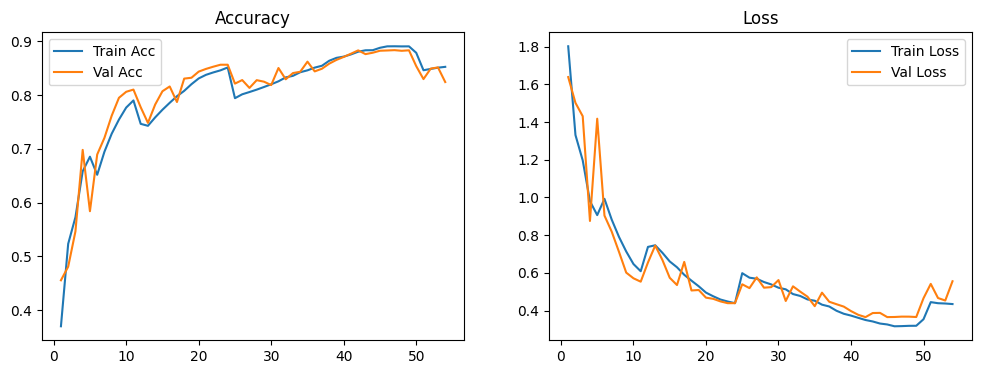

In [25]:
def plot_history(h):
    acc = h.history["accuracy"]
    val_acc = h.history["val_accuracy"]
    loss = h.history["loss"]
    val_loss = h.history["val_loss"]
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history)

In [26]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy : {test_acc*100:.2f}%")

Train Accuracy: 93.57%
Test Accuracy : 87.59%


In [27]:
model.save("submission/saved_model")
print("SavedModel exported → submission/saved_model/")

INFO:tensorflow:Assets written to: submission/saved_model\assets


INFO:tensorflow:Assets written to: submission/saved_model\assets


SavedModel exported → submission/saved_model/


In [28]:
import os
os.makedirs("submission/tflite", exist_ok=True)

# Convert TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()
open("submission/tflite/model.tflite", "wb").write(tflite_model)

# Save labels
labels = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

with open("submission/tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

print("TFLite + label.txt created!")

TFLite + label.txt created!


1/1 [==============================] - 0s 134ms/step
Label asli      : airplane
Prediksi model : airplane


(-0.5, 31.5, 31.5, -0.5)

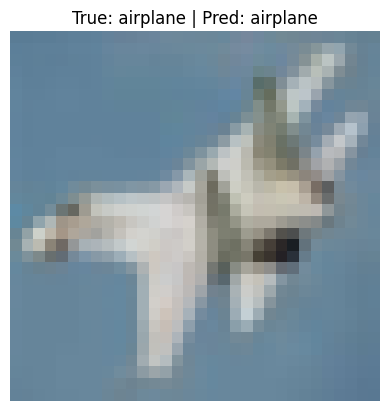

In [ ]:
# Load SavedModel
model = tf.keras.models.load_model("submission/saved_model")

# Load CIFAR-10 sample
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Ambil 1 gambar dari test set
index = 10  # kamu bisa ganti ke angka berapa saja
img = x_test[index]
label = y_test[index][0]

# Preprocess
img_resized = img / 255.0
img_input = np.expand_dims(img_resized, axis=0)

# Predict
pred = model.predict(img_input)
pred_class = pred.argmax()

# Mapping label CIFAR-10
classes = ["airplane","automobile","bird","cat","deer",
           "dog","frog","horse","ship","truck"]

print("Label asli      :", classes[label])
print("Prediksi model :", classes[pred_class])

# Tampilkan gambar
plt.imshow(img)
plt.title(f"True: {classes[label]} | Pred: {classes[pred_class]}")
plt.axis("off")